In [47]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from utils import data_processing
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae

import os
import json
import optuna

## Simulate the initial data

In [9]:
# n_samples = 600
# n_features_bytype = 5
# n_active_features = 3
# treatment_effect = 0.
# surv_type = "surv_weibull"
# feature_types_list = ["real", "cat"]

n_samples = 600
n_features_bytype = 4
n_active_features = 3 
treatment_effect = 0.
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 6.
scale_C_indep = 4.5
feature_types_list = ["pos", "real", "cat"]
independent = False
data_types_create = True

control, treated, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                         n_features_bytype, n_active_features, p_treated, shape_T,
                                         shape_C, scale_C, scale_C_indep, data_types_create, seed=0)

# control, treated, types = simulation(treatment_effect, n_samples,
#                                      n_features_bytype=n_features_bytype,
#                                      n_active_features=n_active_features,
#                                      feature_types_list=feature_types_list) 
                                    #  surv_type=surv_type)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [10]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
1,0.620116,0.987304,0.494666,0.166897,-1.119509,-0.210453,-0.368761,-1.145711,1.0,0.0,0.0,0.0,0.224481,1
4,0.874445,0.820363,1.377438,0.452029,0.226290,0.216713,1.131835,1.369845,1.0,1.0,1.0,1.0,10.935727,1
11,0.386280,0.632000,1.038750,0.349346,-0.678958,0.541789,-0.116268,0.152934,1.0,1.0,0.0,1.0,1.464392,1
12,1.453227,0.145134,0.593687,1.056960,-2.069638,-2.300999,-0.460192,-1.642681,0.0,0.0,0.0,0.0,1.183530,0
14,0.461897,1.139139,0.494944,0.213642,-0.509902,-1.174044,-0.240497,-0.080935,0.0,0.0,0.0,0.0,0.655399,1


In [11]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

percent of uncensored data in control set 0.963 and in treated set 0.970


## Save data

In [12]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control, index=False, header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated, index=False, header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [14]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [15]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [16]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [20]:
# Parameters of the optuna study
multiplier_trial = 10 # multiplier for the number of trials
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 1 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect*10))

In [18]:
# the datasets used for training is data_init_control
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 10
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [48]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                   "HI-VAE_piecewise" : surv_hivae,
                   "Surv-GAN" : surv_gan,
                   "Surv-VAE" : surv_vae}

best_params_dict, study_dict = {}, {}
for generator_name in generators_sel:
    n_trials = int(multiplier_trial * generators_dict[generator_name].get_n_hyperparameters(generator_name))
    print("{} trials for {}...".format(n_trials, generator_name))
    db_file = "optuna_results/optuna_study_{}_ntrials{}_{}.db".format(name_config, n_trials, generator_name)
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
        study = optuna.load_study(study_name="optuna_results/optuna_study_{}_ntrials{}_{}".format(name_config, n_trials, generator_name),
                                  storage="sqlite:///{}".format(db_file))
        study_dict[generator_name] = study
        with open("optuna_results/best_params_{}_ntrials{}_{}.json".format(name_config, n_trials, generator_name), "r") as f:
            best_params_dict[generator_name] = json.load(f)
    else: 
        print("Creating new optuna study for {}...".format(generator_name))
        if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
            feat_types_dict_ext = feat_types_dict.copy()
            for i in range(len(feat_types_dict)):
                if feat_types_dict_ext[i]['name'] == "survcens":
                    if generator_name in["HI-VAE_weibull"]:
                        feat_types_dict_ext[i]["type"] = 'surv_weibull'
                    else:
                        feat_types_dict_ext[i]["type"] = 'surv_piecewise'
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search((data_init_control_encoded, intervals), 
                                                                                                data_init_control,
                                                                                                miss_mask_control, 
                                                                                                true_miss_mask_control,
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_sample=n_generated_dataset, 
                                                                                                n_splits=n_splits,
                                                                                                n_trials=n_trials, 
                                                                                                columns=fnames, 
                                                                                                study_name="optuna_results/optuna_study_{}_ntrials{}_{}".format(name_config, n_trials, generator_name))
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_ntrials{}_{}.json".format(name_config, n_trials, generator_name), "w") as f:
                json.dump(best_params, f)
        else: 
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search(data_init_control, 
                                                                                            columns=fnames, 
                                                                                            target_column="censor", 
                                                                                            time_to_event_column="time", 
                                                                                            n_generated_sample=n_generated_dataset, 
                                                                                            n_splits=n_splits,
                                                                                            n_trials=n_trials, 
                                                                                            study_name="optuna_results/optuna_study_{}_ntrials{}_{}".format(name_config, n_trials, generator_name))
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_ntrials{}_{}.json".format(name_config, n_trials, generator_name), "w") as f:
                json.dump(best_params, f)

50 trials for HI-VAE_weibull...
This optuna study already exists. Please change the name of the study or remove the file to create a new one.


[2025-06-11T11:00:02.518288+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T11:00:02.518806+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T11:00:02.518985+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T11:00:02.519178+0200][68321][CRITICAL] module plugin_decaf load failed
[2025-06-11T11:00:02.525503+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T11:00:02.525823+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T11:00:02.525999+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T11:00:02.526149+0200]

70 trials for HI-VAE_piecewise...
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
110 trials for Surv-GAN...
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
130 trials for Surv-VAE...
This optuna study already exists. Please change the name of the study or remove the file to create a new one.


### Run models with best hyperparameters

In [49]:
best_params_hivae_weibull = best_params_dict["HI-VAE_weibull"]
best_params_hivae_piecewise = best_params_dict["HI-VAE_piecewise"]
best_params_survgan = best_params_dict["Surv-GAN"]
best_params_survae = best_params_dict["Surv-VAE"]

print("Best parameters for HI-VAE Weibull: {}".format(best_params_hivae_weibull))
print("Best parameters for HI-VAE Piecewise: {}".format(best_params_hivae_piecewise))
print("Best parameters for Surv-GAN: {}".format(best_params_survgan))
print("Best parameters for Surv-VAE: {}".format(best_params_survae))

Best parameters for HI-VAE Weibull: {'lr': 0.0002, 'batch_size': 60, 'z_dim': 30, 'y_dim': 10, 's_dim': 30}
Best parameters for HI-VAE Piecewise: {'lr': 0.001, 'batch_size': 60, 'z_dim': 15, 'y_dim': 30, 's_dim': 25, 'n_layers_surv_piecewise': 1, 'n_intervals': 5}
Best parameters for Surv-GAN: {'generator_n_layers_hidden': 1, 'generator_n_units_hidden': 50, 'generator_nonlin': 'leaky_relu', 'generator_dropout': 0.05709989348205056, 'discriminator_n_layers_hidden': 4, 'discriminator_n_units_hidden': 100, 'discriminator_nonlin': 'elu', 'discriminator_dropout': 0.08272669850424155, 'lr': 0.0002, 'weight_decay': 0.001, 'encoder_max_clusters': 10}
Best parameters for Surv-VAE: {'n_iter': 100, 'lr': 0.0001, 'decoder_n_layers_hidden': 1, 'weight_decay': 0.001, 'batch_size': 128, 'n_units_embedding': 500, 'decoder_n_units_hidden': 400, 'decoder_nonlin': 'relu', 'decoder_dropout': 0.18078458629996366, 'encoder_n_layers_hidden': 4, 'encoder_n_units_hidden': 300, 'encoder_nonlin': 'relu', 'encode

In [51]:
# Visualize the results of the optuna study
from optuna.visualization import plot_slice
plot_slice(study_dict["HI-VAE_weibull"])

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

### Run with defaut_params

In [28]:
# the datasets used for training is data_init_control
n_generated_dataset = 100
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.1180, ELBO_train: -14.23320198, KL_z: 2.08461440, KL_s: 0.10077655, reconstruction loss: -12.04781103
Epoch: [100]  time: 1.6685, ELBO_train: -10.57903433, KL_z: 0.87285388, KL_s: 0.04212224, reconstruction loss: -9.66405821
Epoch: [200]  time: 3.3114, ELBO_train: -10.31258059, KL_z: 1.25264263, KL_s: 0.02788723, reconstruction loss: -9.03205073
Epoch: [300]  time: 4.9320, ELBO_train: -10.33053112, KL_z: 1.41222173, KL_s: 0.02877307, reconstruction loss: -8.88953632
Epoch: [400]  time: 6.5441, ELBO_train: -10.12585163, KL_z: 1.57486397, KL_s: 0.03315282, reconstruction loss: -8.51783484
Epoch: [500]  time: 8.1349, ELBO_train: -9.73393536, KL_z: 1.63971937, KL_s: 0.03429091, reconstruction loss: -8.05992508
Epoch: [600]  time: 9.7377, ELBO_train: -10.00468397, KL_z: 1.73475289, KL_s: 0.03187704, reconstruction loss: -8.23805404
Epoch: [700]  time: 11.3135, ELBO_train: -10.16912174, KL_z: 1.85316086, KL_s: 0.03148317, reconstruction lo

[2025-06-11T10:32:37.853494+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:32:37.854449+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:32:37.854813+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:32:37.855251+0200][68321][CRITICAL] module plugin_decaf load failed


Training finished.
Generate data by Surv-GAN
{'fitted': False, 'module_relative_path': PosixPath('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': PosixPath('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


[2025-06-11T10:32:38.016423+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:32:38.016904+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:32:38.017126+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:32:38.017325+0200][68321][CRITICAL] module plugin_decaf load failed
  6%|▋         | 649/10000 [00:30<07:22, 21.11it/s]
[2025-06-11T10:33:16.649827+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:33:16.650869+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:33:16.651239+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


 75%|███████▌  | 750/1000 [00:45<00:15, 16.41it/s]


In [29]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params[generator_name] = generators_dict[generator_name].run(df_init_control_encoded,
                                                                                                miss_mask_control,
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params)
    else:
        data_gen_control_dict_best_params[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0481, ELBO_train: -13.94369888, KL_z: 2.10279810, KL_s: 0.11369193, reconstruction loss: -11.72720885
Epoch: [100]  time: 2.9255, ELBO_train: -11.86880779, KL_z: 0.63442397, KL_s: 0.05994385, reconstruction loss: -11.17443997
Epoch: [200]  time: 5.7486, ELBO_train: -11.39519310, KL_z: 0.53542368, KL_s: 0.05128545, reconstruction loss: -10.80848397
Epoch: [300]  time: 8.6372, ELBO_train: -10.94828296, KL_z: 0.66124164, KL_s: 0.05034310, reconstruction loss: -10.23669823
Epoch: [400]  time: 11.5150, ELBO_train: -10.80446172, KL_z: 0.78802964, KL_s: 0.04829788, reconstruction loss: -9.96813419
Epoch: [500]  time: 14.4561, ELBO_train: -10.64311934, KL_z: 0.86639848, KL_s: 0.04781121, reconstruction loss: -9.72890964
Epoch: [600]  time: 17.3656, ELBO_train: -10.62871456, KL_z: 0.96591152, KL_s: 0.04715580, reconstruction loss: -9.61564724
Epoch: [700]  time: 20.3291, ELBO_train: -10.86119556, KL_z: 1.03510195, KL_s: 0.04698080, reconstruc

[2025-06-11T10:35:20.275752+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:35:20.277012+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:20.277287+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:20.277539+0200][68321][CRITICAL] module plugin_decaf load failed
[2025-06-11T10:35:20.379381+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:35:20.380058+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:20.380316+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:20.380624+0200]

Training finished.
Generate data by Surv-GAN


 10%|█         | 1049/10000 [00:18<02:41, 55.59it/s]
[2025-06-11T10:35:46.407531+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:35:46.408718+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:46.409005+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:46.409681+0200][68321][CRITICAL] module plugin_decaf load failed
[2025-06-11T10:35:46.427301+0200][68321][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-11T10:35:46.428259+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-11T10:35:46.428569+0200][68321][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no

Generate data by Surv-VAE


100%|██████████| 100/100 [00:01<00:00, 57.59it/s]


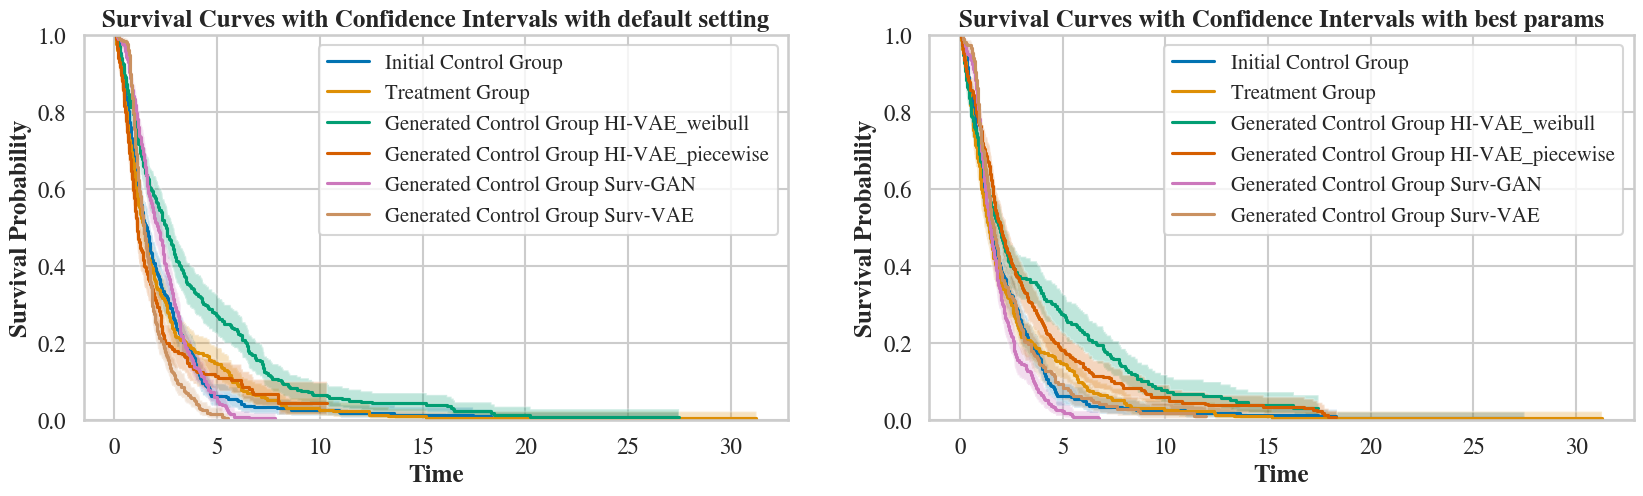

In [30]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[0])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[0])

sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[0])

axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=15)
axs[0].set_xlabel("Time", fontweight="semibold")
axs[0].set_ylabel("Survival Probability", fontweight="semibold")
axs[0].set_title("Survival Curves with Confidence Intervals with default setting", fontweight="bold")

kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[1])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[1])

sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[1])

axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=15)
axs[1].set_xlabel("Time", fontweight="semibold")
axs[1].set_ylabel("Survival Probability", fontweight="semibold")
axs[1].set_title("Survival Curves with Confidence Intervals with best params", fontweight="bold")
plt.show()

In [37]:
# Convert generated data into dataframe
df_gen_control_dict_best_params = {}
df_gen_control_dict_default = {}
df_syn_dict_best_params = {}
df_syn_dict_default = {}
for generator_name in generators_sel:
    list_df_gen_control_best_params = []
    list_df_gen_control_default = []
    data_syn_best_params = []
    data_syn_default = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict_best_params[generator_name][j].numpy(), columns=fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control_best_params.append(df_gen_control_j)
        data_syn_best_params.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))

        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control_default.append(df_gen_control_j)
        data_syn_default.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict_best_params[generator_name] = list_df_gen_control_best_params
    df_gen_control_dict_default[generator_name] = list_df_gen_control_default
    df_syn_dict_best_params[generator_name] = data_syn_best_params
    df_syn_dict_default[generator_name] = data_syn_default

### 3. Compare generation performance

#### 3.1. General metrics

In [ ]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict_best_params[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

In [38]:
general_scores_default = []
for generator_name in generators_sel:
    general_scores_default.append(general_metrics(df_init_control, df_gen_control_dict_default[generator_name], generator_name))
general_scores_default_df = pd.concat(general_scores_default)

##### 3.1.1. Data resemblance

===================== General performance with best params: =====================


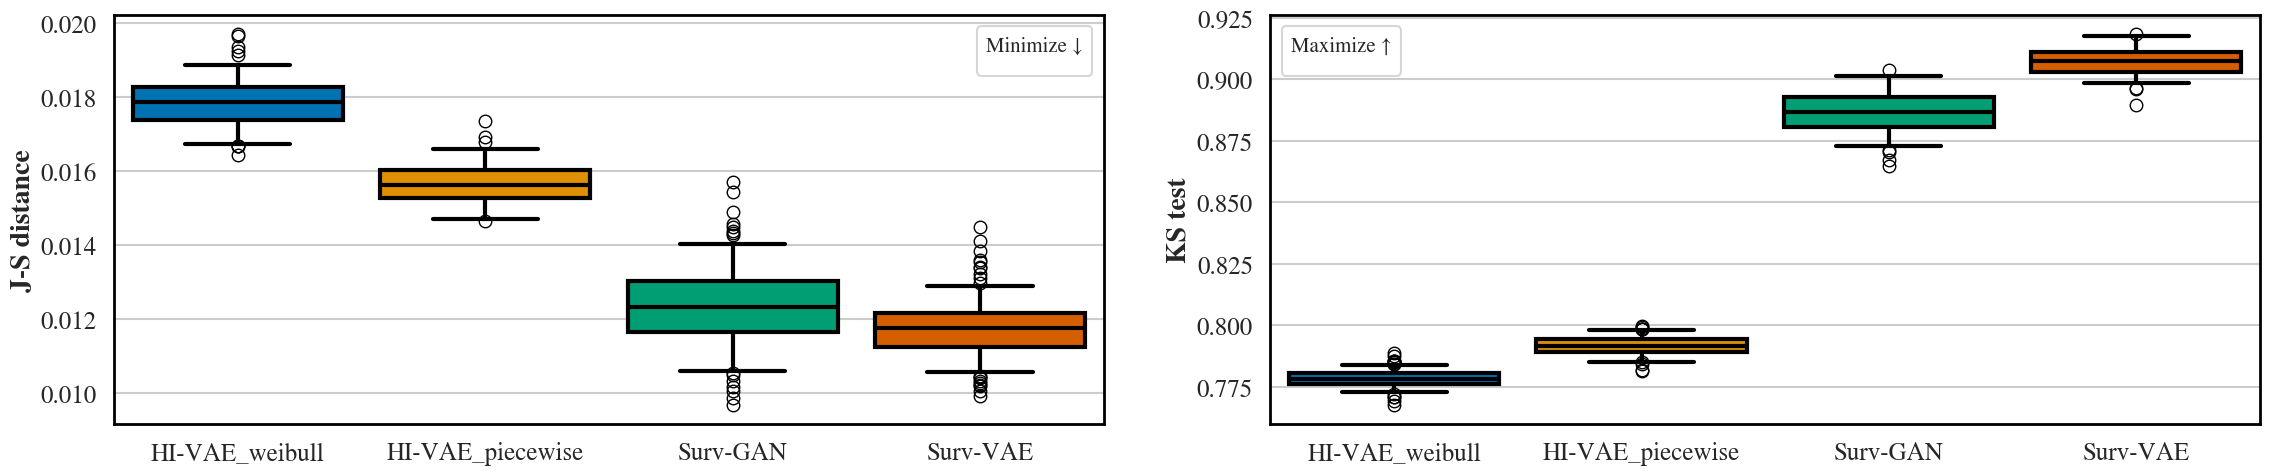

===================== General performance with default params: =====================


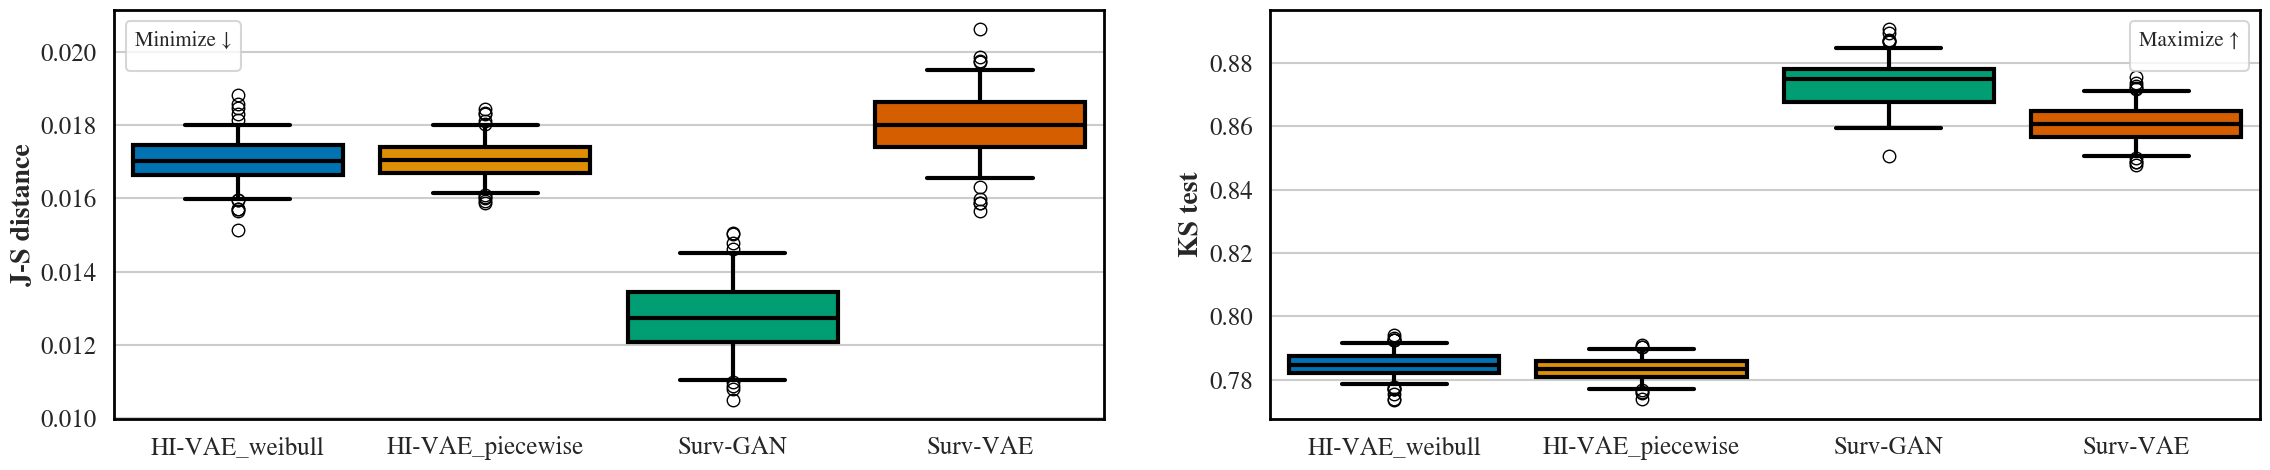

In [39]:
from utils.visualization import visualize_general_perf
print("===================== General performance with best params: =====================")
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

===================== General performance with best params: =====================


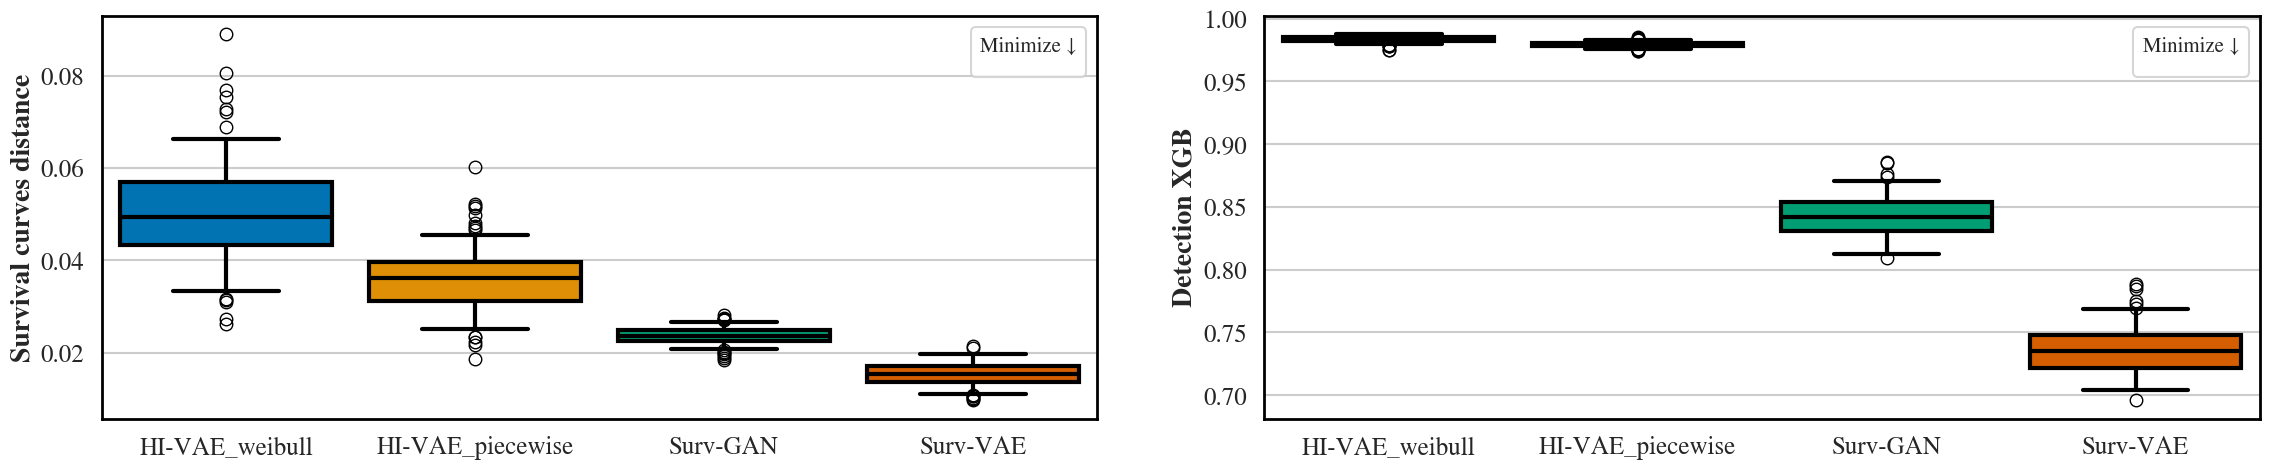

===================== General performance with default params: =====================


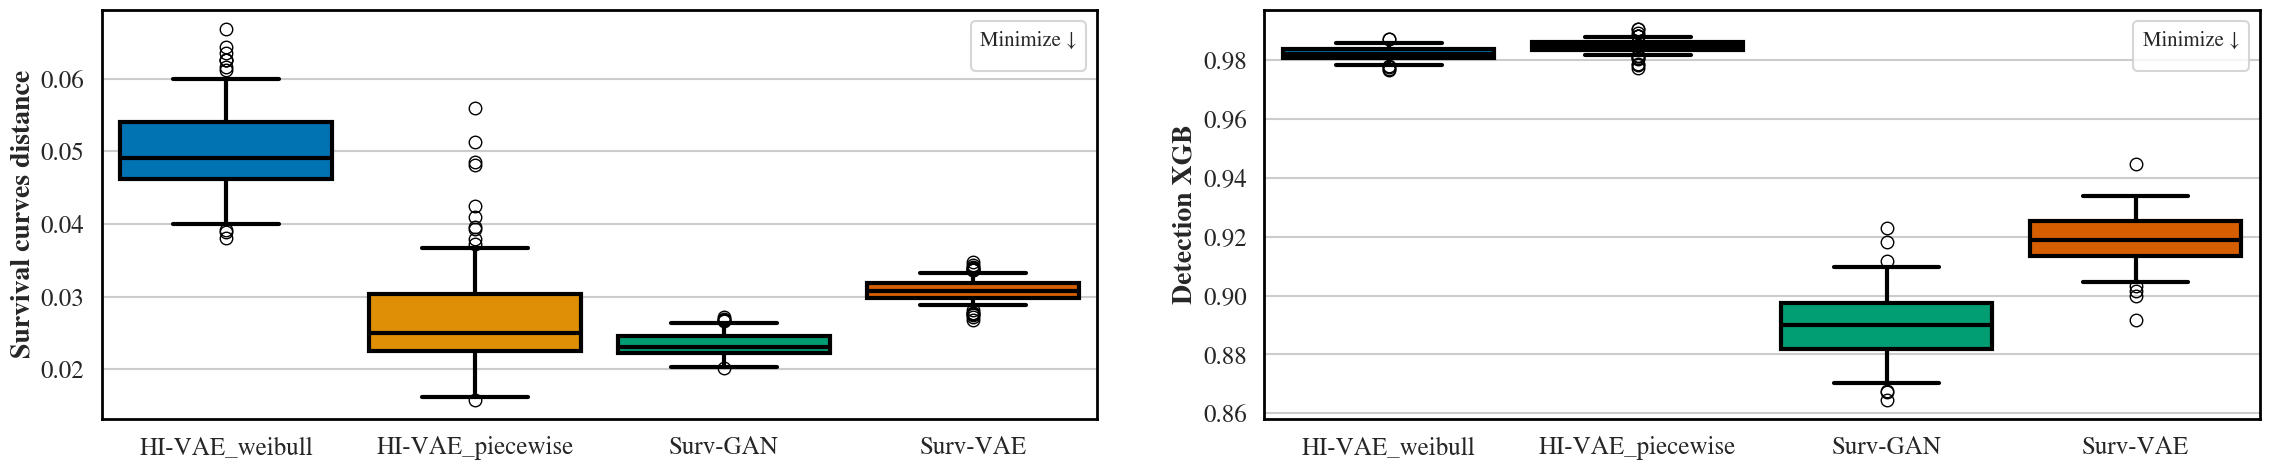

In [40]:
print("===================== General performance with best params: =====================")
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

===================== General performance with best params: =====================


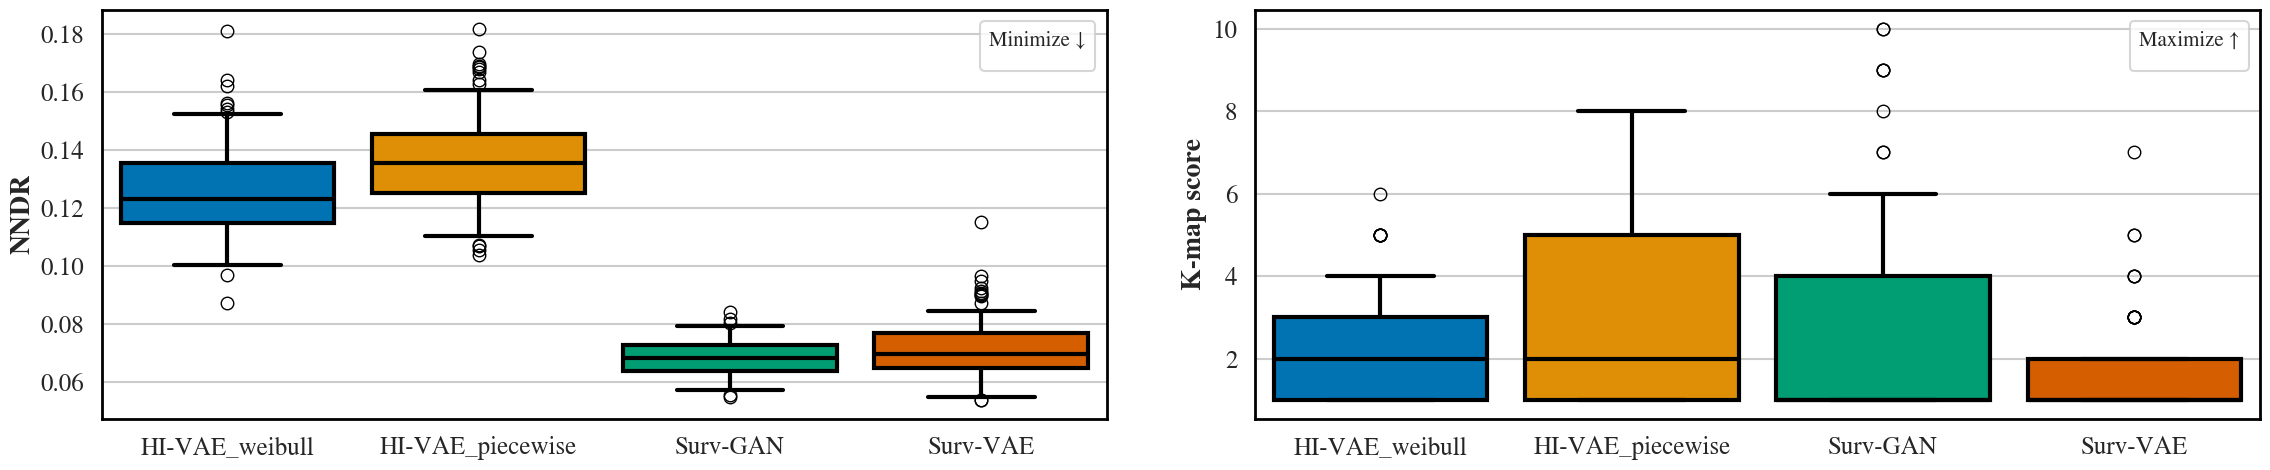

===================== General performance with default params: =====================


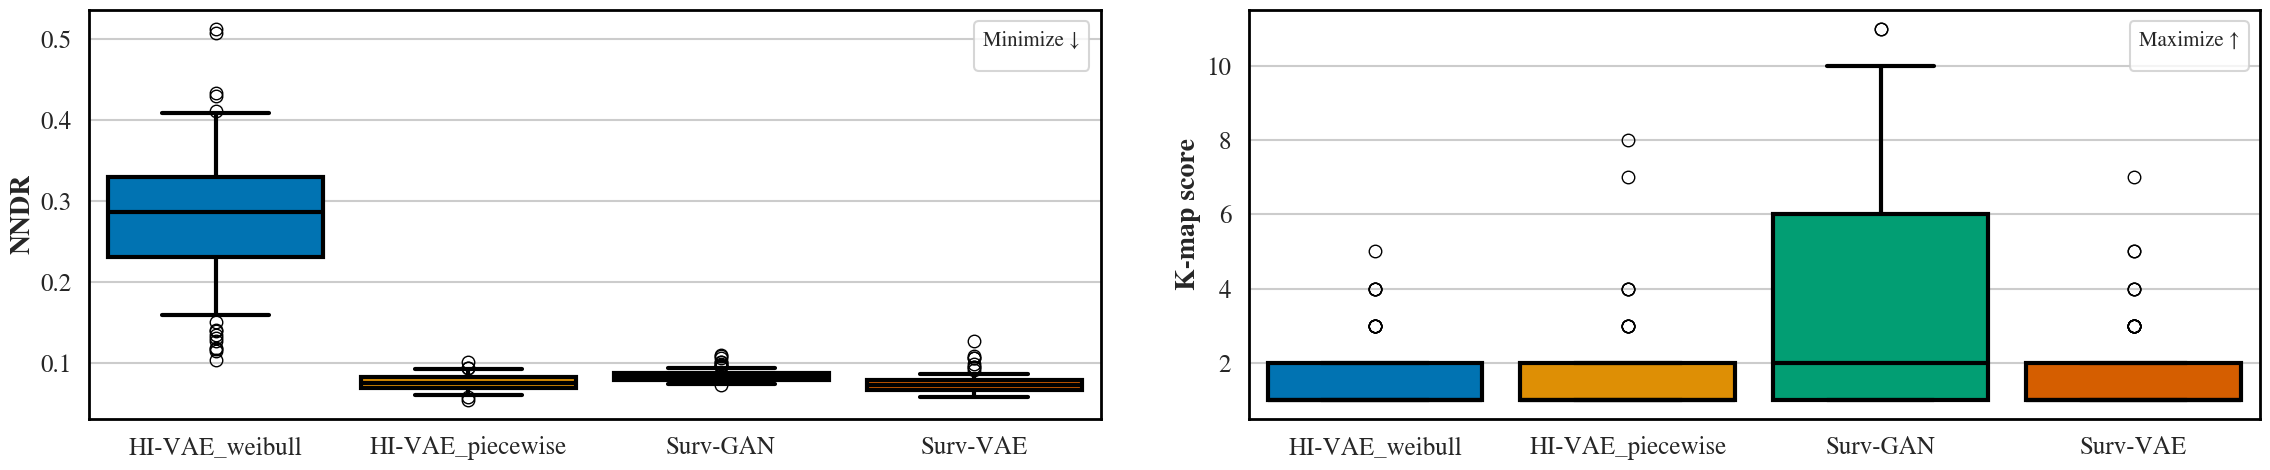

In [41]:
print("===================== General performance with best params: =====================")
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics with best params

In [42]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict_best_params[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

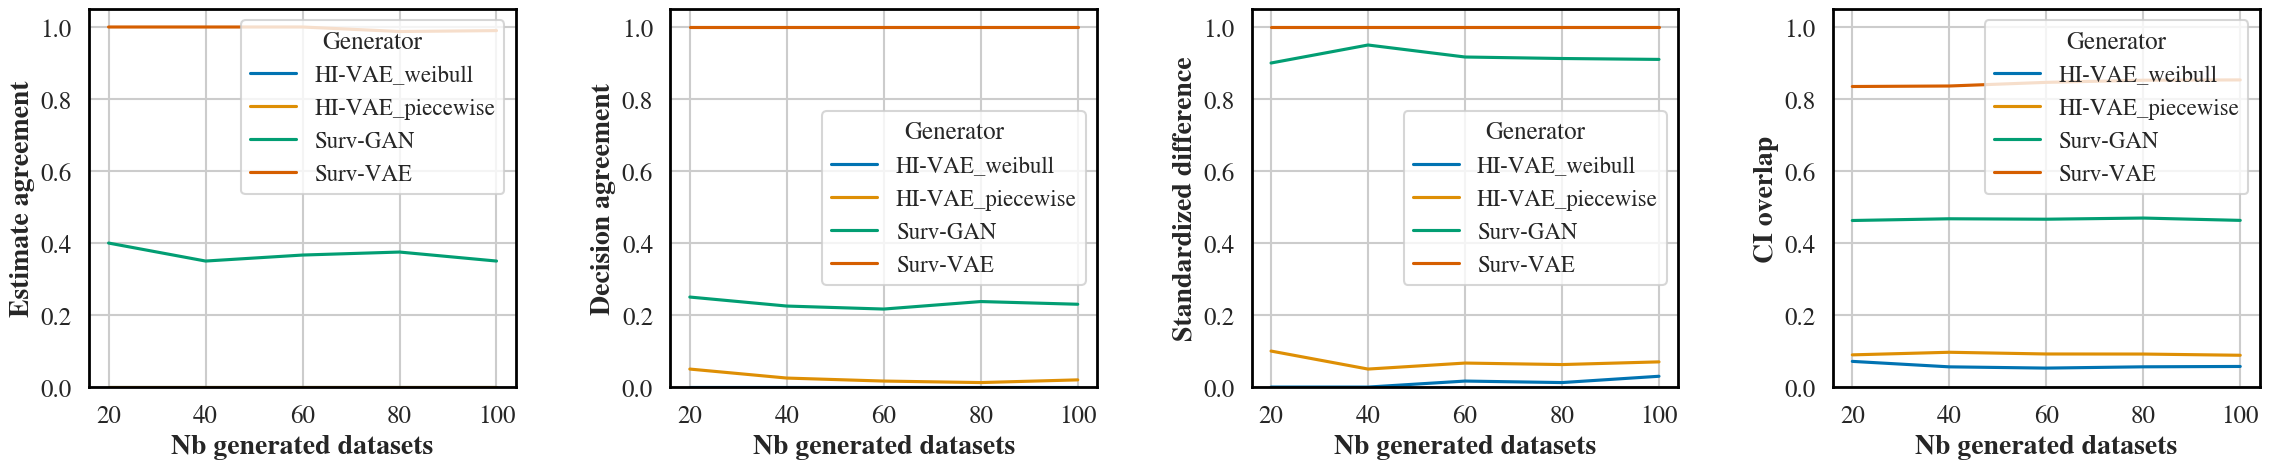

In [43]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [44]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange', 'cyan']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict_best_params[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

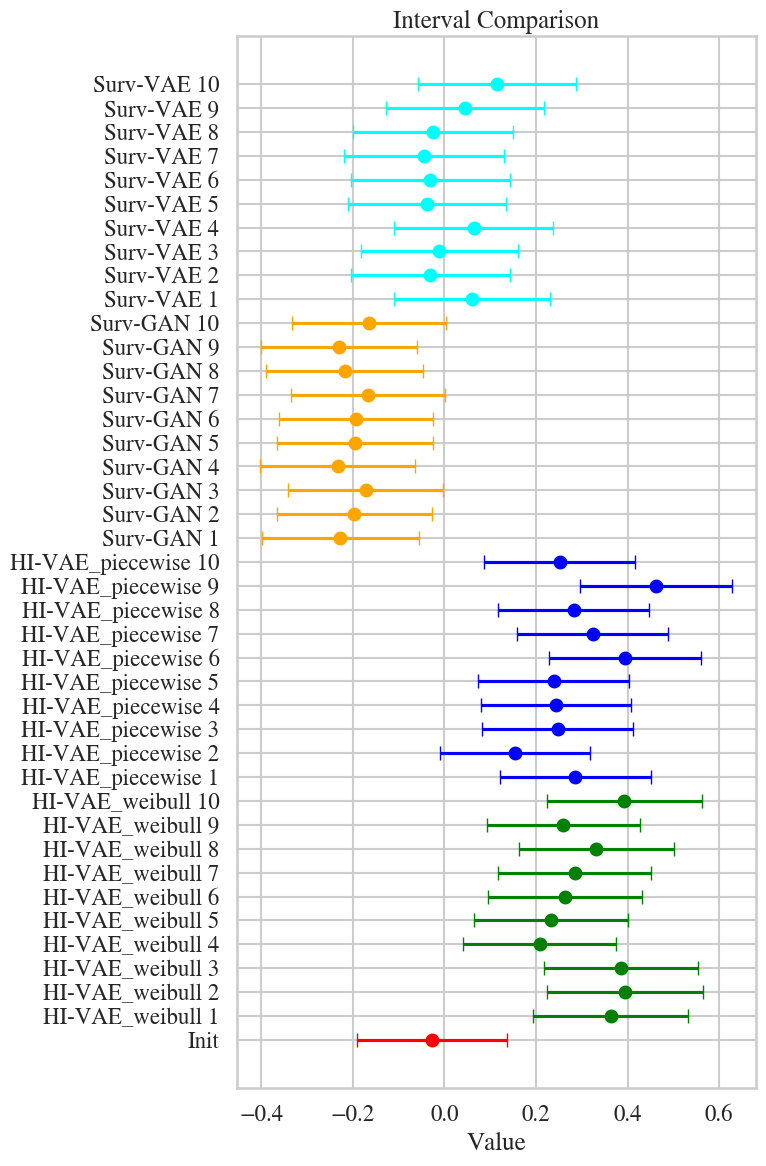

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()